## loading file

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_object_dtype


# Get the base folder of your project (two levels up from /notebook)
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if "__file__" in globals() else os.path.dirname(os.getcwd())

# Build the path to the Excel file inside /data
DATA_PATH = os.path.join(BASE_DIR, "data", "amazon_product_reviews.xlsx")

# Load the file
df = pd.read_excel(DATA_PATH)

print("Data loaded successfully from the 'data' folder!")
print(f"Initial shape of the DataFrame: {df.shape}")

print("\nFirst 5 rows of the dataset:")
print(df.head())


Data loaded successfully from the 'data' folder!
Initial shape of the DataFrame: (1465, 16)

First 5 rows of the dataset:
   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   
3  B08HDJ86NZ  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...   
4  B08CF3B7N1  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...           â‚¹399   
1  Computers&Accessories|Accessories&Peripherals|...           â‚¹199   
2  Computers&Accessories|Accessories&Peripherals|...           â‚¹199   
3  Computers&Accessories|Accessories&Peripherals|...           â‚¹329   
4  Computers&Accessories|Accessories&Peripherals|...           â‚¹154   

  actual_price  discount_perce

## Initial Data Inspection

In [2]:
print("\nDataFrame Info:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nDescriptive statistics for numerical columns:")
print(df.describe())

print("\nUnique values in 'category' column:")
print(df['category'].unique())

print("\nValue counts for 'category' column:")
print(df['category'].value_counts())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1465 non-null   object 
 1   product_name         1465 non-null   object 
 2   category             1465 non-null   object 
 3   discounted_price     1465 non-null   object 
 4   actual_price         1465 non-null   object 
 5   discount_percentage  1465 non-null   float64
 6   rating               1465 non-null   object 
 7   rating_count         1463 non-null   object 
 8   about_product        1465 non-null   object 
 9   user_id              1465 non-null   object 
 10  user_name            1465 non-null   object 
 11  review_id            1465 non-null   object 
 12  review_title         1465 non-null   object 
 13  review_content       1465 non-null   object 
 14  img_link             1465 non-null   object 
 15  product_link         

In [3]:
# --- Data cleaning for downstream sentiment analysis ---

def fix_text_encoding(value):
    if isinstance(value, str):
        try:
            return value.encode("latin1").decode("utf-8")
        except (UnicodeEncodeError, UnicodeDecodeError):
            return value
    return value


def clean_price(series):
    cleaned = (series.astype(str)
               .str.replace(r"[^0-9.,-]", "", regex=True)
               .str.replace(",", "", regex=False)
               .replace({"": np.nan}))
    return pd.to_numeric(cleaned, errors="coerce")


def clean_rating(series):
    extracted = series.astype(str).str.extract(r"([0-9]+(?:\\.[0-9]+)?)")[0]
    return pd.to_numeric(extracted, errors="coerce")


def clean_count(series):
    cleaned = (series.astype(str)
               .str.replace(r"[^0-9]", "", regex=True)
               .replace({"": np.nan}))
    return pd.to_numeric(cleaned, errors="coerce")



## Handling Remaining Missing Values and Saving the Clean Dataset
We'll impute the remaining numeric gaps with median values so downstream models have complete inputs, then export the cleaned file for later steps.


In [4]:
# Ensure numeric columns are clean, fill residual nulls with medians, and persist the cleaned dataset
numeric_cols = ["discounted_price", "actual_price", "discount_percentage", "rating", "rating_count"]
price_columns = ["discounted_price", "actual_price"]

for column in numeric_cols:
    if column in price_columns:
        df[column] = clean_price(df[column])
    elif column == "rating":
        df[column] = clean_rating(df[column])
    elif column == "rating_count":
        df[column] = clean_count(df[column])
    else:
        df[column] = pd.to_numeric(df[column], errors="coerce")

    median_value = df[column].median()
    if column == "rating_count":
        df[column] = df[column].fillna(median_value).round().astype("Int64")
    else:
        df[column] = df[column].fillna(median_value)

clean_data_path = os.path.join(BASE_DIR, "data", "amazon_product_reviews_cleaned.csv")
df.to_csv(clean_data_path, index=False)

print("Filled missing numeric values with medians and saved the cleaned dataset.")
print(f"Saved file: {clean_data_path}")
print("\nRemaining null counts:")
print(df[numeric_cols].isna().sum())

Filled missing numeric values with medians and saved the cleaned dataset.
Saved file: c:\Users\aalqarawi.t\OneDrive - Solutions by stc\Desktop\chatbot\data\amazon_product_reviews_cleaned.csv

Remaining null counts:
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
dtype: int64


## Exploratory Data Analysis
Visualising the cleaned data surfaces key pricing and rating patterns before sentiment modelling.


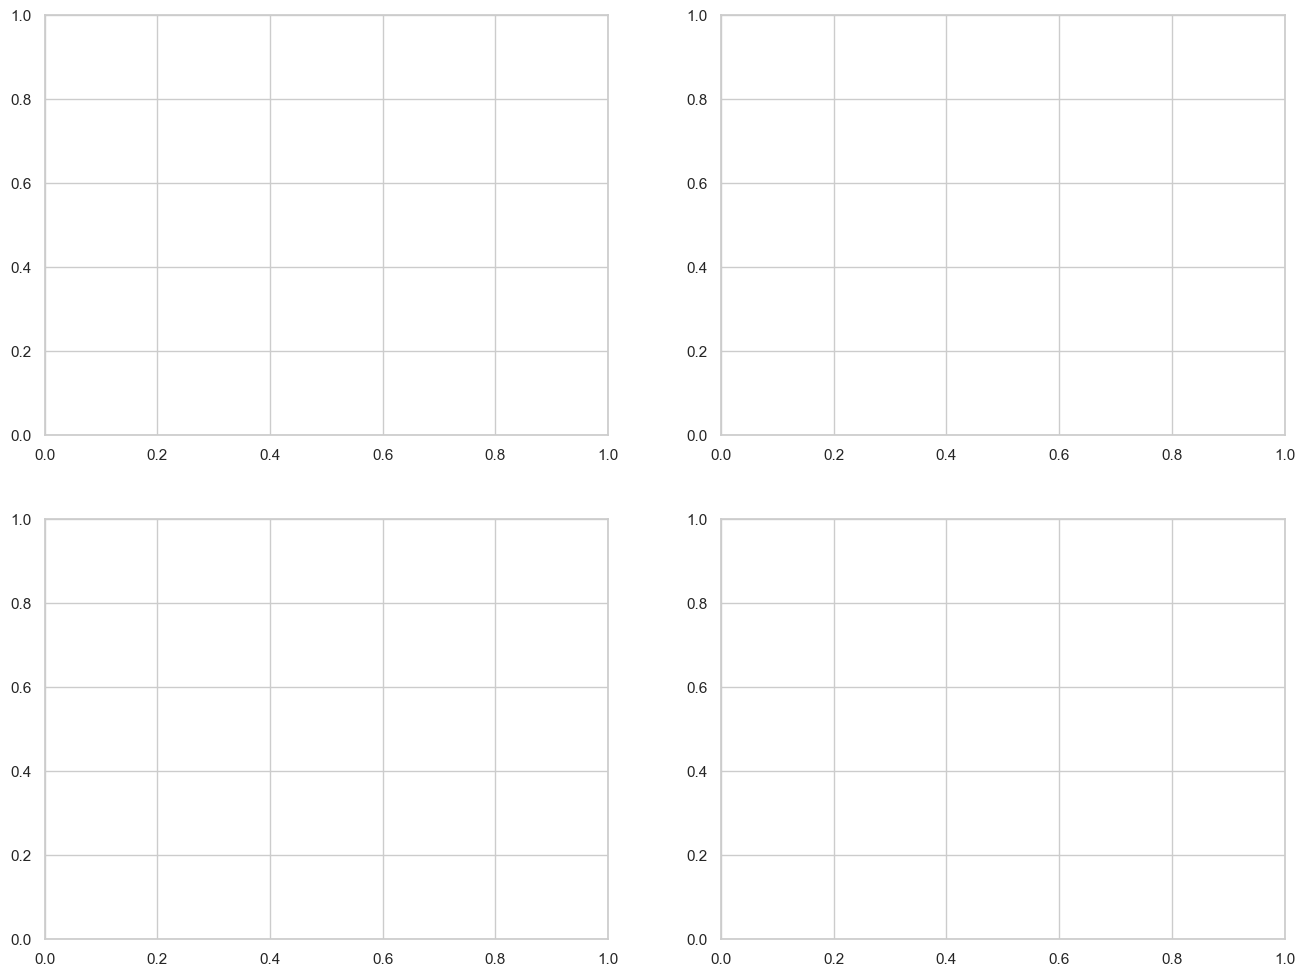

In [5]:
# Key visualisations to understand pricing, discounts, and ratings
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))


In [6]:

# Rating distribution
sns.countplot(ax=axes[0, 0], data=df, x="rating", order=sorted(df["rating"].dropna().unique()))
axes[0, 0].set_title("Rating Distribution")
axes[0, 0].set_xlabel("Rating (Stars)")
axes[0, 0].set_ylabel("Number of Reviews")


Text(4.444444444444459, 0.5, 'Number of Reviews')

In [7]:

# Discount vs actual price scatter
axes[0, 1].scatter(df["actual_price"], df["discount_percentage"], alpha=0.4, s=30)
axes[0, 1].set_title("Discount Percentage vs. Actual Price")
axes[0, 1].set_xlabel("Actual Price (?)")
axes[0, 1].set_ylabel("Discount Percentage")
axes[0, 1].set_xscale("log")
axes[0, 1].set_ylim(0, 1)


(0.0, 1.0)

In [8]:

# Ensure category hierarchy columns exist
if "category_level_1" not in df.columns:
    categories_split = df["category"].astype(str).str.split("|", regex=False)
    max_levels = int(categories_split.map(len).max())
    for level in range(max_levels):
        df[f"category_level_{level + 1}"] = categories_split.str[level].str.strip()


In [9]:

# Top categories by volume (level 1)
top_categories = (df["category_level_1"].fillna("Unknown")
                  .value_counts()
                  .head(10)
                  .sort_values(ascending=True))
sns.barplot(ax=axes[1, 0], x=top_categories.values, y=top_categories.index, orient="h")
axes[1, 0].set_title("Top 10 Category Level 1 Segments")
axes[1, 0].set_xlabel("Number of Reviews")
axes[1, 0].set_ylabel("Category Level 1")


Text(4.444444444444459, 0.5, 'Category Level 1')

In [10]:

# Rating vs review volume
sns.boxplot(ax=axes[1, 1], data=df, x="rating", y=np.log10(df["rating_count"].replace(0, np.nan)), order=sorted(df["rating"].dropna().unique()))
axes[1, 1].set_title("Review Volume (log10) by Rating")
axes[1, 1].set_xlabel("Rating (Stars)")
axes[1, 1].set_ylabel("log10(Review Count)")

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [11]:
# Numeric summaries to contextualise the charts
if "category_level_1" not in df.columns:
    categories_split = df["category"].astype(str).str.split("|", regex=False)
    max_levels = int(categories_split.map(len).max())
    for level in range(max_levels):
        df[f"category_level_{level + 1}"] = categories_split.str[level].str.strip()

summary_stats = {
    "avg_discount_pct": df["discount_percentage"].mean().round(3),
    "median_actual_price": df["actual_price"].median(),
    "median_discounted_price": df["discounted_price"].median(),
    "median_rating": df["rating"].median(),
    "median_rating_count": int(df["rating_count"].median()),
}

rating_by_category = (df.groupby("category_level_1")
                        ["rating"].mean()
                        .dropna()
                        .sort_values(ascending=False)
                        .head(5))

print("Key summary statistics:")
for key, value in summary_stats.items():
    print(f"  {key}: {value}")

print("\nTop 5 categories (level 1) by average rating:")
for category, avg_rating in rating_by_category.items():
    print(f"  {category}: {avg_rating:.2f}")

high_discount = df[df["discount_percentage"] >= 0.7]
print(f"\nProducts with >=70% discount: {len(high_discount)} ({len(high_discount) / len(df):.1%} of dataset)")

Key summary statistics:
  avg_discount_pct: 0.477
  median_actual_price: 1650.0
  median_discounted_price: 799.0
  median_rating: 4.0
  median_rating_count: 5179

Top 5 categories (level 1) by average rating:
  Health&PersonalCare: 4.00
  OfficeProducts: 4.00
  Toys&Games: 4.00
  HomeImprovement: 4.00
  Computers&Accessories: 3.84

Products with >=70% discount: 247 (16.9% of dataset)
